In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.preprocessing_numpy import *
from HN_decomposition.Subspace.ESPRIT_numpy import *

def RMS(x):
        return np.std(x)

figsize = (8.5/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

### Creating a basic modulated sine-wave

In [3]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .1

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
#x = sineAmp*np.sin(full_phase)
#x += noiseAmp*np.random.randn(np.shape(t)[0])


## Loading the audio file

In [4]:
fileName = os.path.join('..', 'Data', 'Test', '69.wav')
x, sr_hz = librosa.load(fileName)
x = x[:2*sr_hz]



In [5]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "preprocessing", "Figures")

## Sub-band decomposition

(44100,)


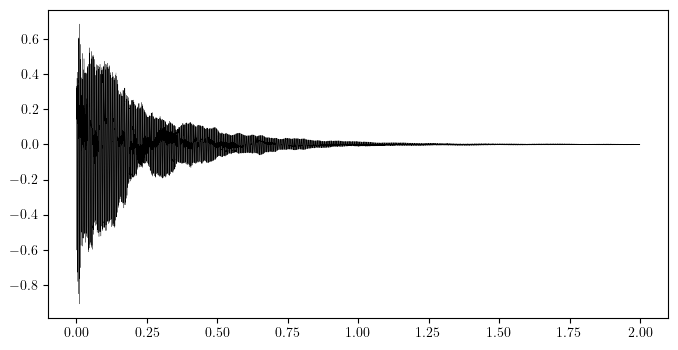

In [6]:

def filter_n_decimate(filterLength_smp : int, numBands : int, inputSignal : np.array):
    """
    args :
        - filterLength : [int]
            Digital filter length, in samples
        - numBands : [int]
            Number of frequency channels in which the signal is to be separated
        - inputSignal : [(1, N) np.array]
            Input signal 
    returns :
        - outputSignals : [(numBands, N) np.array]
            Output signal"""
    signalLength_smp = np.shape(inputSignal)[0] #Input signal length
    filteredSignal = np.zeros((signalLength_smp, numBands)) #initializing the output signal
    
    #h = scipy.signal.remez(numtaps = filterLength_smp, bands = [0, 1/(2*numBands), 1/(2*numBands), .5], fs = 1)

    for i in range(numBands):
        filteredSignal[:,i] = inputSignal

    filters = np.zeros((filterLength_smp, numBands))

    n = np.arange(filterLength_smp)
    base_filter = np.zeros(filterLength_smp)
    for i in range(filters):
        filters[i] = base_filter
    
    outputSignal = filteredSignal[::numBands]
    return outputSignal



print(np.shape(x))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x))/sr_hz, x, 'k', linewidth = .2)
plt.show()

## Whitening the noise

In [7]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440*4/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .01

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
x = sineAmp*np.sin(full_phase)
x += noiseAmp*np.random.randn(np.shape(t)[0])


In [8]:
rankFilter_bins = 21
rankFilter_rank = .3

n_fft = 512
hop_length = n_fft

In [16]:

print(np.shape(x))
x_stft = librosa.stft(x ,n_fft = n_fft, hop_length = hop_length, center=False)

xRankFiltered_stft = rankFilter_stft(x_stft, rankFilter_bins = rankFilter_bins, rankFilter_rank = rankFilter_rank)

window_type = 'hann'
xWhitened, xChopped, ARFilters = window_and_whiten_signal(
    x = x,
    window_length = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)
xWhitened_stft = compute_stft_from_whitened(xWhitened, window_type=window_type)

t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

print(f'sample rate : {sr_hz}')

time_frame_display = 11


(44100,)
sample rate : 22050


## Base ESPRIT

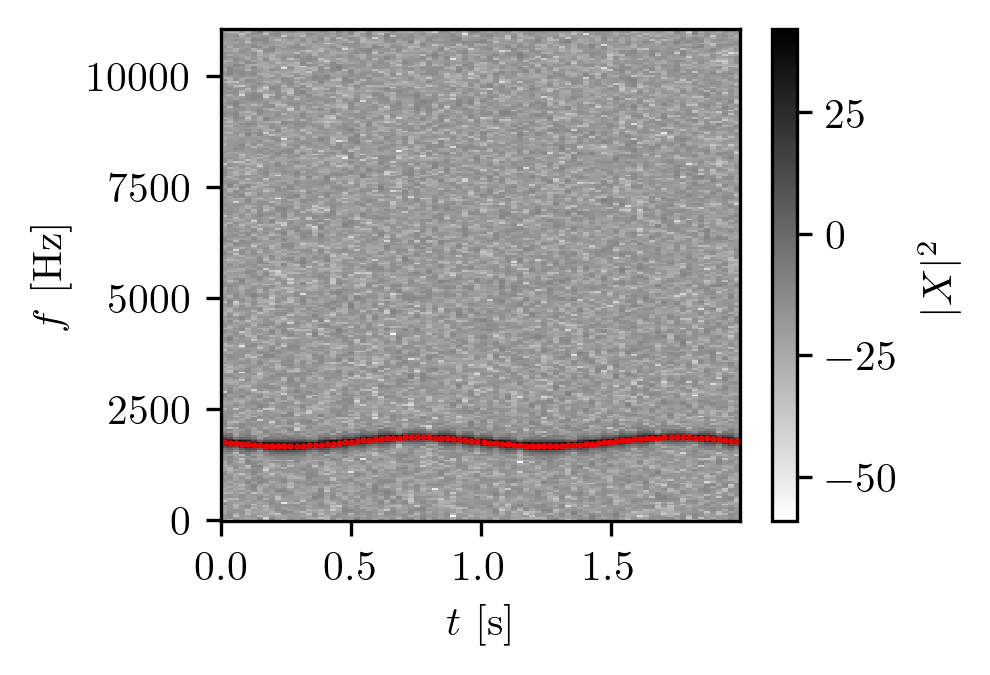

In [19]:
num_poles = 2

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, rasterized=True)

xHarmoChopped = np.zeros(np.shape(xChopped))
xHarmo = np.zeros(np.shape(x))

for timeFrame in range(np.shape(xWhitened)[0]):
    poles, complexAmp, Lambda = ESPRIT(xWhitened[timeFrame], num_poles = num_poles)
    freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]
    plt.plot(np.ones(num_poles//2)*t_list[timeFrame], freqs, 'r.', markersize = 1)
    for i, pole in enumerate(poles):
        xHarmoChopped[timeFrame] += np.real(np.power(pole*np.ones(np.shape(xHarmoChopped)[1]), np.arange(np.shape(xHarmoChopped)[1]))*complexAmp[i])
    xHarmoChopped[timeFrame] = sig.lfilter([1], ARFilters[timeFrame], xHarmoChopped[timeFrame])
    xHarmo[hop_length*timeFrame:hop_length*timeFrame+n_fft] += xHarmoChopped[timeFrame]
    
display(Audio(x, rate = sr_hz))
display(Audio(xHarmo, rate = sr_hz))
display(Audio(x-xHarmo, rate = sr_hz))

scipy.io.wavfile.write(os.path.join('HN/Subspace/Audio', 'input.wav'), rate =sr_hz, data = normalize(x))
scipy.io.wavfile.write(os.path.join('HN/Subspace/Audio', 'harmo.wav'), rate =sr_hz, data = normalize(xHarmo))
scipy.io.wavfile.write(os.path.join('HN/Subspace/Audio', 'noise.wav'), rate =sr_hz, data = normalize(x-xHarmo))

plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
#plt.savefig(fname = os.path.join(save_folder, "ESPRIT_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()




## Adaptative ESPRIT

In [20]:
sr_hz = 22050
length_sec = .1

def mod_sine(length_sec, baseFreq, modFreq, modAmp, sr_hz=1):
    t = np.arange(int(length_sec*sr_hz))
    full_phase = baseFreq/sr_hz*t + modAmp/sr_hz/(2*np.pi*modFreq/sr_hz)*np.cos(2*np.pi*modFreq/sr_hz*t)
    full_phase *= 2*np.pi
    return np.sin(full_phase)

x = np.zeros(int(length_sec*sr_hz), dtype = 'float64')
x += 1*mod_sine(length_sec=length_sec, baseFreq = 440, modFreq = 1, modAmp = 100, sr_hz=sr_hz)
x += .5*mod_sine(length_sec=length_sec, baseFreq = 5500, modFreq = .6, modAmp = 2000, sr_hz=sr_hz)
x += .5*mod_sine(length_sec=length_sec, baseFreq = 6600, modFreq = .6, modAmp = 2000, sr_hz=sr_hz)

x += .1*np.random.randn(int(length_sec*sr_hz))

fileName = os.path.join('..', 'Data', 'Test', '76.wav')
x, sr_hz = librosa.load(fileName)
x = x[int(.1*sr_hz):int((length_sec+.1)*sr_hz)]



In [26]:
import scipy.linalg


def norm2(x):
    return np.sum(np.square(x))

def HRHATRAC_numpy(xChopped:npt.ArrayLike, num_poles:int, beta:float = 1, mu_L:float = .5, mu_V = .5):
    """
    Performs the HRAHATRAC algorithm [1] with the Fast Approximate Power Iteration subspace-tracker [2].
   
    args :
        - x : array-like
            input signal
        - num_poles : int
            dimension of the signal space 
        - beta : float
            forgetting factor
        - mu_L : float

        - mu_V : float

    returns:
        - poles_list : array-like
            List of the poles for each time frame
        - complexAmp_list : array-like
            List of the domplex amplitudes of the signal poles
        

    References :
    [1] David, B., R. Badeau, and G. Richard. 'HRHATRAC Algorithm for Spectral Line Tracking of Musical Signals.'
    In 2006 IEEE International Conference on Acoustics Speed and Signal Processing Proceedings,
    3:III-45-III–48. Toulouse, France: IEEE, 2006. https://doi.org/10.1109/ICASSP.2006.1660586.

    [2] Badeau, R., B. David, and G. Richard. 'Fast Approximated Power Iteration Subspace Tracking.'
    IEEE Transactions on Signal Processing 53, no. 8 (August 2005): 2931–41. https://doi.org/10.1109/TSP.2005.850378.
    """
    

    # Getting the number of samples in each window and the number of samples
    num_windows, window_size = np.shape(xChopped)

    #Initializing output arrays
    poles_list = np.matrix(np.zeros((num_windows, num_poles)), dtype= 'complex128')
    complexAmp_list = np.matrix(np.zeros((num_windows, num_poles), dtype = 'complex128'))

    # Initializing
    W = np.matrix(np.concatenate((np.eye(num_poles, dtype = 'complex128'),np.zeros((window_size - num_poles, num_poles), dtype = 'complex128')), axis = 0), dtype = 'complex128')
    Psi = np.matrix(W[:-1,:].H@W[1:,:], dtype=  'complex128')
    
    Z = np.matrix(np.eye(num_poles, dtype = 'complex128'))
    poles = np.zeros(num_poles, dtype = 'complex128')

    for window_idx in range(num_windows):
        x = np.matrix(xChopped[window_idx], dtype = "complex128").T

        # FAPI
        y = W.H@x
        h = Z@y
        g = h/(beta+(y.H@h))
        eps2 = norm2(x)-norm2(y)
        norm2g = norm2(g)
        tau = eps2/(1+eps2*norm2g + np.sqrt(1+eps2*norm2g))
        eta = 1-tau*norm2g
        yprim = eta*y + tau*g
        hprim = Z.H@yprim
        eps_bf = (tau/eta)*(Z@g - (hprim.H@g)[0,0]*g)
        Z = (Z - g@hprim.H + eps_bf@g.H)/beta
        e = eta*x - W@yprim
        W1 = np.matrix(W, dtype = 'complex128')
        W += e@g.H
        
        ## Tracking the spectral matrix
        e_minus = W1[:-1,:].H@e[1:,:]
        e_plus =  W1[1:,:].H@e[:-1,:]
        e_plusprim =  e_plus + g*((e[1:,:].H@e[:-1,:])[0,0])
        
        nu = W[-1].H
        Psi += e_minus@g.H + g@e_plusprim.H
        
        phi = Psi.H@nu
        Phi = Psi + nu@phi.H/(1 - norm2(nu))

        # Updating the poles

        if window_idx < 1:
            poles, V = np.linalg.eig(Phi)
            Lambda = np.matrix(np.diag(poles), dtype = 'complex128')
            Lambda_inv = np.matrix(np.diag(1/poles), dtype = 'complex128')
        else:
            Lambda = (1-mu_L)*Lambda + mu_L*np.diag(np.diag(np.linalg.inv(V)@Phi@V))
            Lambda_inv = np.matrix(np.diag(1/np.diag(Lambda)), dtype='complex128')
            E_V = V - Phi@V@Lambda_inv
            V = (1-mu_V)*V + mu_V*(Phi@V@Lambda_inv + Phi.H@E_V@Lambda_inv.H)
            V = V/np.sqrt(np.sum(np.square(np.abs(V)), axis = 0)) # Normalization
        poles_list[window_idx] = np.diag(Lambda)
    return poles_list



Temps d'execution : 1.1591603755950928


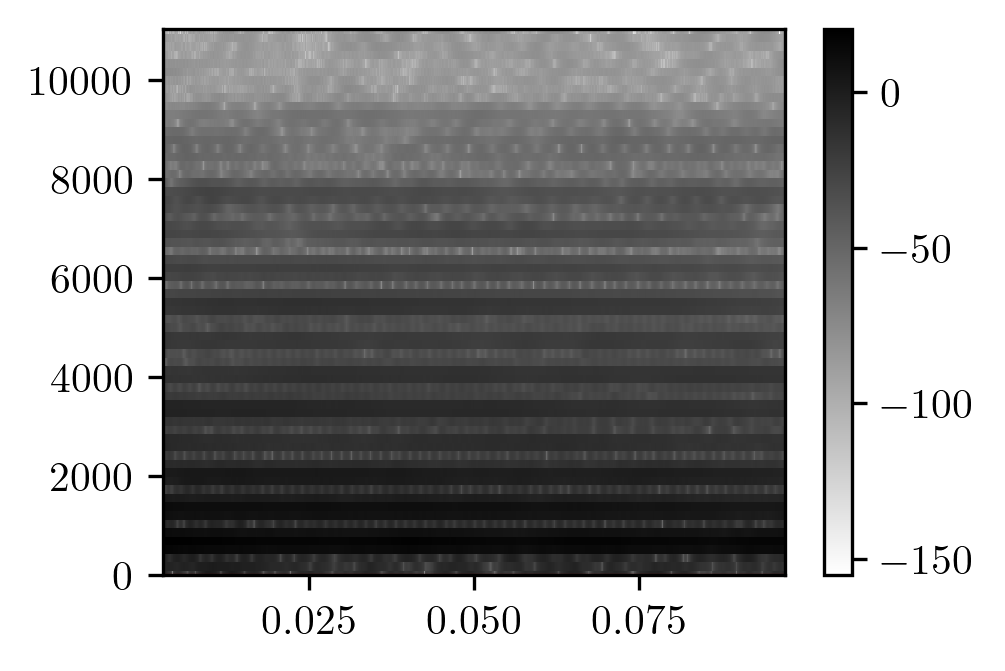

In [46]:
rankFilter_bins = 7
rankFilter_rank = .3

n_fft = 128
hop_length = 2

num_poles = 2

x_stft = librosa.stft(x, n_fft = n_fft, hop_length = hop_length, center=False)

tic = time.time()
xWhitened, xChopped, ARFilters = window_and_whiten_signal(
    x = x,
    window_length = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 8,
    window_type=window_type)


poles_list = HRHATRAC_numpy(
    xWhitened,
    num_poles = num_poles,
    beta = .99,
    mu_L = .5,
    mu_V = .5
)

toc = time.time()
print(f"Temps d'execution : {toc-tic}")
xWhitened_stft = compute_stft_from_whitened(xWhitened, window_type=window_type)
t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

freqs_list = sr_hz*np.angle(poles_list)/(2*np.pi)
plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(xWhitened_stft), cmap = cmap, rasterized=True)
for pole_idx in range(num_poles):
    plt.plot(t_list,freqs_list[:,pole_idx], 'r-', alpha = .5)
plt.ylim(0, 11025)
plt.colorbar()
plt.show()
